# Summary :  
```
data_dir = "./kaggle/input/data"
data_files = read_files(data_dir)

transform = transformers.Compose [ Resize, ToTensor ]
dataset = ImageFolder(data_dir, transform)

index = range(0,len(data_files),subsample)
sampler = SubsetRandomSampler(index)

data_loader = DataLoader(dataset, sampler, batch_size=4)
```

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# installs
!python3 -m pip install --upgrade pip
%pip install torch
%pip install torchvision
%pip install matplotlib

# imports
import os
import json
import torch
import torchvision
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split
%matplotlib inline

print("done")

In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all 
# files under the input directory

seg_counts = {
    "seg_train": 0,
    "seg_test": 0,
    "seg_pred": 0
}
for dirname, _, filenames in os.walk('./kaggle/input'):
    num_files = len(filenames)
    if num_files > 0:
        for key in seg_counts.keys():
            if key in dirname:
                seg_counts[key] += num_files

print("seg_counts:\n", json.dumps(seg_counts, indent=4))

In [ ]:
def create_subset_random_sampler(len: int, subsample: int, random_seed: int):
    index = range(0, len, subsample)
    torch.manual_seed(random_seed)
    return torch.utils.data.SubsetRandomSampler(index)

subsample = 10

train_sampler = create_subset_random_sampler(
    len=seg_counts['seg_train'], 
    subsample=subsample, 
    random_seed=1234)
print("train_sampler:", train_sampler)

test_sampler = create_subset_random_sampler(
    len=seg_counts['seg_test'], 
    subsample=subsample, 
    random_seed=6789)
print("test_sampler:", test_sampler)


> # **Exploring the data_dirs

In [ ]:
#project name
project_name = 'natural-scene-classification'

train_data_dir = "./kaggle/input/seg_train/"
test_data_dir = "./kaggle/input/seg_test"
pred_data_dir = "./kaggle/input/seg_pred"

train_building_files = os.listdir(train_data_dir + '/buildings')
print(f"train_building_files : {len(train_building_files)}")
print(train_building_files[:5])

test_building_files = os.listdir(test_data_dir + '/buildings')
print(f"test_building_files : {len(test_building_files)}")
print(test_building_files[:5])

> # Creating the datasets

In [63]:
transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor()
])

train_dataset = ImageFolder(train_data_dir,transform=transform)

test_dataset = ImageFolder(test_data_dir,transform=transform)

def dataset_summary(dataset):
    print("dataset:", dataset)
    print(f"dataset len: {len(dataset)}")
    print(f"dataset classes:", dataset.classes)
    img, label = dataset[0]
    print("dataset[0] label:", label)
    print("dataset[0] class:", dataset.classes[label])
    print("dataset[0] img.shape:", img.shape)

print("train_dataset:")
dataset_summary(train_dataset)

print("test_dataset:")
dataset_summary(test_dataset)

train_dataset:
dataset: Dataset ImageFolder
    Number of datapoints: 14034
    Root location: ./kaggle/input/seg_train/
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
dataset len: 14034
dataset classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
dataset[0] label: 0
dataset[0] class: buildings
dataset[0] img.shape: torch.Size([3, 100, 100])
test_dataset:
dataset: Dataset ImageFolder
    Number of datapoints: 3000
    Root location: ./kaggle/input/seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
dataset len: 3000
dataset classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
dataset[0] label: 0
dataset[0] class: buildings
dataset[0] img.shape: torch.Size([3, 100, 100])


> # Visualizing dataset images :

In [64]:
def display_img(dataset, index):
    img, label = dataset[index]
    print(f"Class : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

Class : buildings


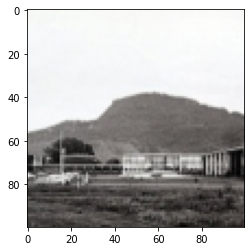

In [65]:
display_img(train_dataset, 0)

Class : buildings


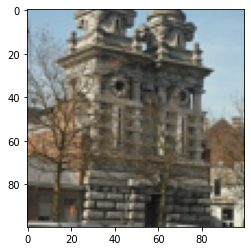

In [66]:
display_img(train_dataset, 1000)

Class : street


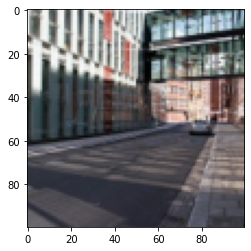

In [67]:
display_img(train_dataset, 14000)

> # Load the datasets into batches:

In [76]:
train_dl = DataLoader(train_dataset, sampler=train_sampler, batch_size=8)
test_dl = DataLoader(test_dataset, sampler=test_sampler, batch_size=8)

In [77]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

> # Show image grids of batches :

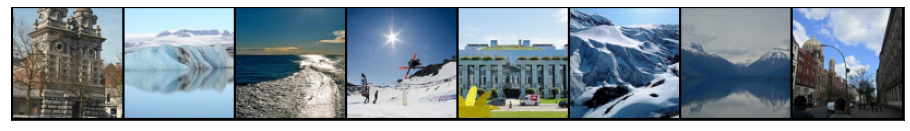

In [78]:
show_batch(train_dl)

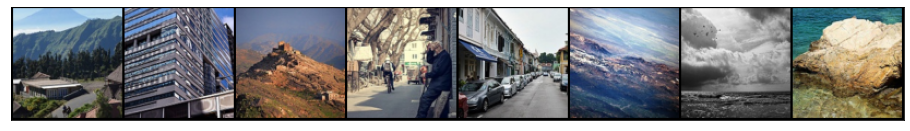

In [79]:
show_batch(test_dl)

> # Base Model for Image Classification:

In [80]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Netural Scene Classfication Model:

In [81]:
class NaturalSceneClassification(ImageClassificationBase):
    
    def __init__(self):
        
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [82]:
model = NaturalSceneClassification()
model

NaturalSceneClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Li

In [83]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([8, 3, 100, 100])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x36864 and 82944x1024)

Helper Function or classes to Load Data into GPU

In [ ]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [ ]:
device = get_default_device()
device

In [ ]:
# load the into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

> # **Model Fitting**

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [ ]:
#load the model to the device
model = to_device(NaturalSceneClassification(),device)

In [ ]:
#initial evaluation of the model
evaluate(model,val_dl)

In [ ]:
#set the no. of epochs, optimizer funtion and learning rate
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
#fitting the model on training data and record the result after each epoch
history = fit(num_ep
              
              
              
              ochs, lr, model, train_dl, val_dl, opt_func)

> # Graphs for Model Accuracy and Losses :

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

In [ ]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

> # Evaluate Test Data :

In [ ]:
# Apply the model on test dataset and Get the results
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

In [ ]:
#save the model
torch.save(model.state_dict(), 'natural-scene-classification.pth')

> ## Predicting for individual images:

In [ ]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = to_device(img.unsqueeze(0), device)
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return dataset.classes[preds[0].item()]

In [ ]:
from PIL import Image

#open image file
img = Image.open("./kaggle/input/seg_pred/10004.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model)}")

In [ ]:
#open image file
img = Image.open("./kaggle/input/seg_pred/10100.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model)}")

In [ ]:
#open image file
img = Image.open("./kaggle/input/seg_pred/10241.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model)}")

In [ ]:
img.shape

<!-- Save the parmeters to jovian plateform -->